In [47]:
import hope
hope.config.optimize = True
hope.config.verbose = True
hope.config.keeptemp = True
import numba
import numpy as np
from util import perf_comp_data
from native_util import load
%load_ext Cython
%load_ext version_information
%version_information numpy, Cython, numba, hope

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.5.1 64bit [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
numpy 1.13.1
Cython 0.26
numba 0.34.0
hope 0.6.1
Mon Sep 04 16:22:08 2017 CEST

In [2]:
b = 3.5
a = 1. / np.sqrt(2. ** (1. / (b - 1.)) - 1.)

r50 = 2

center = np.array([10.141, 10.414])
dims = np.array([20, 20])
# coefficients generated by http://keisan.casio.com/has10/SpecExec.cgi?id=system/2006/1280624821, 7th order
x1D = np.array([ \
      0.5 - 0.9491079123427585245262 / 2 \
    , 0.5 - 0.7415311855993944398639 / 2 \
    , 0.5 - 0.4058451513773971669066 / 2 \
    , 0.5 \
    , 0.5 + 0.4058451513773971669066 / 2 \
    , 0.5 + 0.7415311855993944398639 / 2 \
    , 0.5 + 0.9491079123427585245262 / 2 \
], dtype=np.float32)
w1D = np.array([ \
      0.1294849661688696932706 / 2 \
    , 0.2797053914892766679015 / 2 \
    , 0.38183005050511894495 / 2 \
    , 0.4179591836734693877551 / 2 \
    , 0.38183005050511894495 / 2 \
    , 0.2797053914892766679015 / 2 \
    , 0.1294849661688696932706 / 2 \
], dtype=np.float32)
w2D = np.outer(w1D, w1D)

print(dims.dtype)

int64


In [3]:
def pdf(density, dims, center, w2D, r50, b, a):
    for x in range(dims[0]):
        for y in range(dims[1]):
            dr = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
            density[x, y] = np.sum(w2D * 2 * (b - 1) / (2 * np.pi * (r50 * a)**2) * (1 + (dr / (r50 * a))**2)**(-b))
    return density

In [44]:
%%cython -f
#Naive Cython implementation
cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def cython_pdf(np.ndarray[np.float32_t, ndim=2] density, 
               np.ndarray[np.long_t, ndim=1] dims, 
               np.ndarray[np.float_t, ndim=1] center, 
               np.ndarray[np.float32_t, ndim=2] w2D, 
               float r50, 
               float b, 
               float a):
    
    cdef double dr = 0.0
    
    for x in range(dims[0]):
        for y in range(dims[1]):
            dr = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
            density[x, y] = np.sum(w2D * 2 * (b - 1) / (2 * np.pi * (r50 * a)**2) * (1 + (dr / (r50 * a))**2)**(-b))
    return density

building '_cython_magic_f24e61fd7e336481e3f458d73845fd48' extension
C compiler: /usr/bin/clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -arch i386 -arch x86_64 -g

compile options: '-I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/sit

In [42]:
%%capture
%%cython -f
#Modestly tunned Cython implementation
cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def cython_pdf_opt(np.ndarray[np.float32_t, ndim=2] density, 
               np.ndarray[np.int64_t, ndim=1] dims, 
               np.ndarray[np.float64_t, ndim=1] center, 
               np.ndarray[np.float32_t, ndim=2] w2D, 
               float r50, 
               float b, 
               np.float32_t a):
    
    cdef np.float32_t pi = np.pi
    cdef np.float32_t dr = 0.0
    cdef long x, y
    cdef double fac, cx, cy
    
    cx = center[0]
    cy = center[1]
    
    cdef float s = np.sum(w2D)
    
    for x in range(dims[0]):
        for y in range(dims[1]):
            dr = ((x - center[0]) ** 2 + (y - center[1]) ** 2)**(0.5)
            fac = 2. * (b - 1.) / (2. * pi * (r50 * a)**2) * (1. + (dr / (r50 * a))**2)**(-b)
            density[x, y] = fac * s
    return density

In [48]:
%%cython
#Aggresively tunned Cython implementation
cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def cython_pdf_unrolled(np.ndarray[np.float32_t, ndim=2] density, 
               np.ndarray[np.long_t, ndim=1] dims, 
               np.ndarray[np.float_t, ndim=1] center, 
               np.ndarray[np.float32_t, ndim=2] w2D, 
               float r50, 
               float b, 
               float a):

    cdef float pi = np.pi
    cdef int x,y,k,m
    cdef float s,dr,d
    cdef Py_ssize_t fac_x = 7
    cdef Py_ssize_t fac_y = 7
    cdef np.ndarray[np.float32_t, ndim=2] fac = np.zeros([fac_x, fac_y], dtype=np.float32)
    cdef float w2D_fac = 2 * (b - 1) / (2 * pi * (r50 * a)**2)

    for k in range(fac_x):
        for m in range(fac_y):
            fac[k, m] = w2D[k, m] * w2D_fac

    for x in range(dims[0]):
        for y in range(dims[1]):
            dr = ((x - center[0]) ** 2 + (y - center[1]) ** 2)**(1./2)
            d = (1 + (dr / (r50 * a))**2)**(-b)
            
            s = 0
            for k in range(fac_x):
                for m in range(fac_y):
                    s += fac[k, m] * d
            density[x, y] = s
    return density

building '_cython_magic_7c009ac0db35df252e00390b32bc6500' extension
C compiler: /usr/bin/clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -arch i386 -arch x86_64 -g

compile options: '-I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/sit

In [20]:
hope.config.keeptemp= True
hope.config.optimize=True
hope_pdf = hope.jit(pdf) 
numba_pdf = numba.jit(pdf, nopython=False)

native_pdf_mod = load("pdf")
native_pdf = native_pdf_mod.run

running build_ext
building 'pdf' extension
C compiler: /usr/bin/clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -arch i386 -arch x86_64 -g

compile options: '-I/Users/uweschmitt/Projects/hope/venv3/lib/python3.5/site-packages/numpy/core/include -I/Users/uweschmitt/Projects/hope/venv3/include -I/Library/Frameworks/Python.framework/Versions/3.5/include/python3.5m -c'
extra options: '-Wall -Wno-unused-variable -march=native -stdlib=libc++ -std=c++11 -Wno-unreachable-code'
clang: ././src/pdf.cpp
/usr/bin/clang++ -bundle -undefined dynamic_lookup -arch i386 -arch x86_64 -g ./src/pdf.o -o ./pdf.cpython-35m-darwin.so



In [45]:
density = np.zeros((dims[0], dims[1]), dtype=np.float32)
pdf(density, dims, center, w2D, r50, b, a)

hdensity = np.zeros((dims[0], dims[1]), dtype=np.float32)
hope_pdf(hdensity, dims, center, w2D, r50, b, a)

ndensity = np.zeros((dims[0], dims[1]), dtype=np.float32)
numba_pdf(ndensity, dims, center, w2D, r50, b, a)

cdensity = np.zeros((dims[0], dims[1]), dtype=np.float32)
cython_pdf(cdensity, dims, center, w2D, r50, b, a)

c2density = np.zeros((dims[0], dims[1]), dtype=np.float32)
cython_pdf_opt(c2density, dims, center, w2D, r50, b, a)

c3density = np.zeros((dims[0], dims[1]), dtype=np.float32)
cython_pdf_unrolled(c3density, dims, center, w2D, r50, b, a)

nadensity = np.zeros((dims[0], dims[1]), dtype=np.float32)
native_pdf(nadensity, dims, center, w2D, r50, b, a)

assert np.allclose(density, hdensity)
assert np.allclose(density, ndensity)
assert np.allclose(density, cdensity)
assert np.allclose(density, c2density)
assert np.allclose(density, c3density)
assert np.allclose(density, nadensity)


In [46]:
print("Python")
%timeit pdf(density, dims, center, w2D, r50, b, a)
print("hope")
%timeit hope_pdf(density, dims, center, w2D, r50, b, a)
print("Numba")
%timeit numba_pdf(density, dims, center, w2D, r50, b, a)
print("Cython")
%timeit cython_pdf(density, dims, center, w2D, r50, b, a)
print("Cython opt")
%timeit cython_pdf_opt(density, dims, center, w2D, r50, b, a)
print("Cython unrolled")
%timeit cython_pdf_unrolled(density, dims, center, w2D, r50, b, a)
print("Native")
%timeit native_pdf(density, dims, center, w2D, r50, b, a)


Python
7.48 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
hope
119 µs ± 2.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Numba
185 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Cython
4.97 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cython opt
27.3 µs ± 675 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Cython unrolled
39.1 µs ± 816 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Native
50.4 µs ± 695 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
funcs = ["pdf", 
         "numba_pdf", 
         "hope_pdf", 
         "cython_pdf", 
         "cython_pdf_opt", 
         "cython_pdf_unrolled",
         "native_pdf", 
         ]
perf_comp_data(funcs, 
               len(funcs)*["density, dims, center, w2D, r50, b, a"], rep=100)

function: cython_pdf_opt      , av. time sec:   0.00002623, min. time sec:   0.00002379, relative:       1.0
function: cython_pdf_unrolled , av. time sec:   0.00004890, min. time sec:   0.00004316, relative:       1.9
function: native_pdf          , av. time sec:   0.00005467, min. time sec:   0.00004636, relative:       2.1
function: hope_pdf            , av. time sec:   0.00013511, min. time sec:   0.00010329, relative:       5.2
function: numba_pdf           , av. time sec:   0.00018622, min. time sec:   0.00017234, relative:       7.1
function: cython_pdf          , av. time sec:   0.00461271, min. time sec:   0.00386866, relative:     175.9
function: pdf                 , av. time sec:   0.00688719, min. time sec:   0.00635740, relative:     262.6


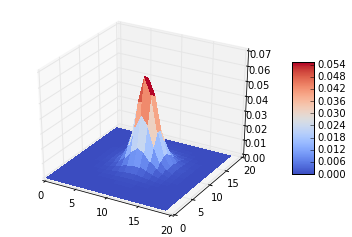

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

density = np.zeros((dims[0], dims[1]), dtype=np.float32)
pdf(density, dims, center, w2D, r50, b, a)

fig = plt.figure()
ax = fig.gca(projection='3d')
gx, gy = np.mgrid[0:dims[0], 0:dims[1]]
surf = ax.plot_surface(gx, gy, density, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()